In [ ]:
# Source: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/data

# Imports.


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

#!cd 'drive/MyDrive/Datasets/galaxy-zoo'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# We start by importing the python libraries that we will use

import numpy as np
import numpy.random as rnd
import itertools 
import os
import sys
import pandas as pd

from sklearn.metrics import mean_squared_error

# Tensorflow library used for implementation of the DNNs
import tensorflow as tf

import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# The Galaxy classification problem.


The galaxy classification problem usually consists of, given an input (commonly an image), predict what is the inputs probability of belonging to a particular class C.

Here, this problem is applied to a dataset used in one of the Kaggle challenges: The galaxy-zoo dataset.

## Galaxy-zoo.

Galaxy-zoo is an online crowdsourcing project where random selected users have been asked to, given an image of a galaxy in colour, "describe" its morphology.

In order to do that, since it cannot be expected for random individuals to be experts on galactic matters, the users were given a set of questions that would serve as "gidelines" for the aforementioned descriptions. This questions could range from describing more general features like "*How rounded is the galaxy?*", to in depth more specific questions: "*Does it have a central bulge?*". 

Since the system for the descriptions was based on questions, this could be easily seen as a decision tree.

### The galaxy-zoo decision tree.

The galaxy-zoo decision tree is a simple in depth decision tree that allowed the randomly selected individuals to do an accurate prediction of the probabilities of X galaxy being of class C. The decision tree consists of 11 questions that divide the tree, which ends up with 37 possible classes for every single galaxy.

The decision tree (and thereby its questions) has been designed to encompass all points in the traditional Hubble-tuning-fork as well as a range of more irregular morphologies. The hubble-tuning-fork ([*The Hubble tuning fork - classification of galaxies*](https://www.spacetelescope.org/images/heic9902o/)) is a basic classification scheme of galaxies designed by the american astronomer Edwin Hubble in 1926. Even thought, as can be seen below, the idea is pretty simple, it still holds as a solid reference for galaxy classification.


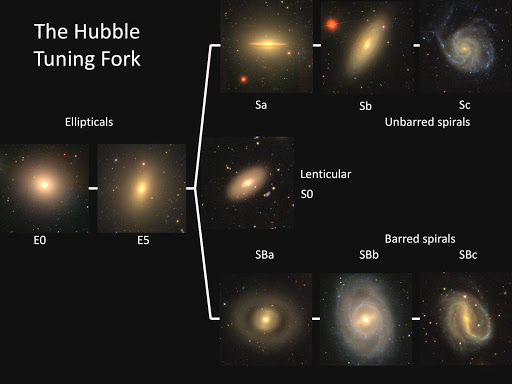

Now we can see how the galaxy-zoo decision tree is a more "in depth" version of the Hubble-tuning-fork. For starters, as mentioned above, the galaxy-zoo decision tree consists of the following 11 questions:

* Q1. Is the object a smooth galaxy, a galaxy with features/disk or a star?
*   Q2. Is it edge-on?
*   Q3. Is there a bar? 
*  Q4. Is there a spiral pattern?
*   Q5. How prominent is the central bulge?
*   Q6. Is there anything "odd" about the galaxy?
*   Q7. How round is the smooth galaxy?
*  Q8. What is the odd feature?
*   Q9. What shape is the bulge in the edge-on galaxy?
*   Q10. How tightly wound are the spiral arms? 
*   Q11. How many spiral arms are there?

Every question does not necessarily have the same number of answers as the rest. For example, Q2 (*Is it edge-on?*) has two possible responses, while some others like Q11 (*How many spiral arms are there?*) has up to 6 responses. This is due to the binary nature of some questions (yes/no) while some others the answer might be between several options (more than 2) or it needs to be chosen between a range of numbers (like Q11).

The original versions given to the participants of the galaxy-zoo proyect can be seen below:
 




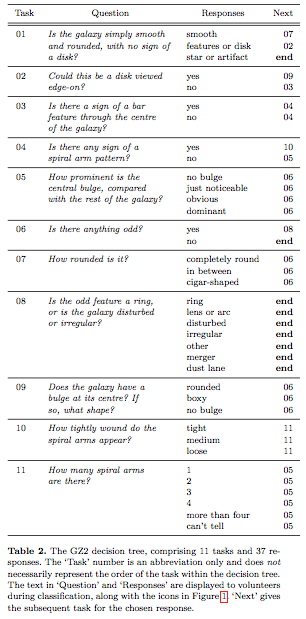

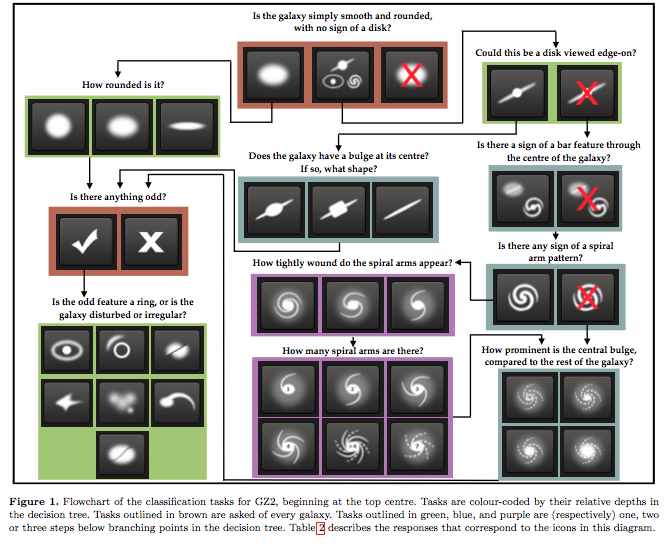


Lets see how the probabilities of the tree work now. For starters, at each node or question, the total initial probability of a classification will sum to 1.0. In order to compute the values that can be seen in the solution files, the following steps are taken:

* For the first set of responses (smooth, features/disk, star/artifact), the values in each class are the likelihood of the galaxy falling in a given class C. These values will always sum to 1.0.

* For the rest of following questions, first the probabilities are computed (will still sum to 1.0) and then they will be multiplied by a value P, where P is the value that led to that new set of answers. Due to this multiplication, this new probabilities will NOT sum to 1.0.

The reason for this following step multiplication is that in order for a solution to be good, it needs to emphasize that it must get the high-level, large-scale morphology categories correct. A side effect of this is that, alongside what was mentioned before, a good solution will have a good accuracy on the further down the decision tree.

Since this weigthing can be seen as a little confusing when can use the following example given by the own Galaxy-Zoo team:


```py
# Given a galaxy that had the following user descriptions:

80% of the users indentified it as smooth.
15% of the users indentified it as having features / disks.
5% of the users indentified it as a star / artifact.

ClassSmooth = 0.80; ClassFeaDisk = 0.15; ClassStarArt = 0.05;

# Lets go more in depth. Given the 80% of users that classified the galaxy 
# as "smooth", they also recorded responses for the galaxy's relative roundness. 

50% of the users indentified it as completely round.
25% of the users indentified it as inbetween round.
The rest of the users identified it as cigar-shaped.

# Applying the rules, our new probabilities for the new classes would be:

ClassCRound    = 0.80 * 0.50 = 0.40;
ClassInBewteen = 0.80 * 0.25 = 0.20;
ClassCigar     = 0.80 * 0.25 = 0.20;

# As we can see, the probabilities do no longer sum to 1.0.
```
As a side note, mention that because of the structure of the decision tree, each individual participant answered only a subset of the questions for each classification (since it followed the tree structure).
When many participants have classified the same image,
their answers are aggregated into a set of weighted vote fractions
for the entire decision tree. These vote fractions are used to estimate
confidence levels for each answer, and are indicative of the difficulty
users experienced in classifying the image.

*Note: due to problems with the enviroment, the executions had been made during several iterations.*



# Our approach to the galaxy-zoo problem.

## But first, what are we actually predicting?

After the previous explanations, it still can be a little be confusing to see what we are actually predicting. If take into account that the given answer probabilities are derived from the previously mentioned crowsourcing method, we can imply that these are biased and or noisy. Since we are learning from it, we can expect a model M to learn and exhibit those biases B. The intuition here is that every built model M will not model the actual "true" morphology, but **they model how the crowd would classify the images**,  which may or may not correspond with the actual true label.

In the end, what we are learning can be, since we learn how the crowd would classify the images, taken as if we were actually learning the human interpretation of the decision tree used by the crowd.

## Our model.

### Data loading and preprocessing.


We use pandas framework to load the .csv data into easy to controll and manage datasets. We don't crop or reshape any image early, like other works would do. Instead of that, we decided a easier and more dinamic way of approaching this. 

Since CNNs are already computationally expensive, and taking into account we are working with a large size of images that already have a high disk-space requirement to save them all, we decided to use a trick, it consisting in using KERAS cropping2D layers at the start of our CNN, in such a way that the initial cropping we would apply to all the images, applies at the start to every input. This is really efficient since KERAS functions are made to be fast and computationally cheap, while also we gain the advantage of only preprocessing the images we are gonna use, so it's more dynamic.

In [ ]:
# Provisional / Quitar luego 
# Paths Unai:
data_folder = '/content/drive/MyDrive/Datasets/galaxy-zoo/'
models_folder = '/content/drive/MyDrive/UNI/AÑO 4/MLNN/Galaxy-Zoo/models/'

# Paths Alex:
# data_folder = "/content/drive/MyDrive/galaxy-zoo/"
# models_folder = "/content/drive/MyDrive/Galaxy-Zoo/models/"


In [ ]:
# First with load the features into a pandas dataframe:
df = pd.read_csv(data_folder+'training_solutions_rev1.csv')
df = df[:15000]
df['GalaxyID'] = df['GalaxyID'].astype(str) + '.jpg'

# We can visualize it easily:
df


,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008.jpg,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.00000,0.027226,0.000000,0.027226,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.000000,0.0,0.0,0.325512
1,100023.jpg,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.00000,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.00000,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.0,0.0,0.000000
2,100053.jpg,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,100078.jpg,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.00000,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.00000,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.000000,0.0,0.0,0.000000
4,100090.jpg,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,322036.jpg,0.072262,0.927738,0.000000,0.116058,0.811680,0.267508,0.544172,0.730921,0.080759,0.0,0.318173,0.470733,0.022774,0.657676,0.342324,0.000000,0.072262,0.000000,0.09085,0.022383,0.272550,0.204083,0.045425,0.022383,0.0,0.087044,0.00000,0.029015,0.072908,0.293117,0.364896,0.137276,0.342459,0.137276,0.0,0.0,0.113910
14996,322038.jpg,0.293031,0.706969,0.000000,0.406227,0.300742,0.081079,0.219663,0.033424,0.267319,0.0,0.076943,0.223799,0.000000,0.113973,0.886027,0.000000,0.059803,0.233228,0.00000,0.000000,0.028493,0.000000,0.085480,0.000000,0.0,0.348136,0.05809,0.000000,0.000000,0.000000,0.033424,0.000000,0.000000,0.000000,0.0,0.0,0.033424
14997,322045.jpg,0.907651,0.042665,0.049684,0.000000,0.042665,0.000000,0.042665,0.000000,0.042665,0.0,0.042665,0.000000,0.000000,0.177683,0.822317,0.884052,0.023599,0.000000,0.00000,0.076150,0.025383,0.000000,0.050767,0.025383,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
14998,322056.jpg,0.165013,0.806159,0.028828,0.763733,0.042426,0.000000,0.042426,0.042426,0.000000,0.0,0.042426,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.165013,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.118616,0.00000,0.645117,0.000000,0.000000,0.042426,0.000000,0.000000,0.000000,0.0,0.0,0.042426


### Data augmentation.

Data augmentation consists on several approaches that modify the training data in ways that change the input representation while keeping the label the same (rotating an image, for example). This is usually both a cheap way to add new data (increase our train dataset size) and a way to add prior knowledge to the CNN. We also use this as a way to add some regularization to our model, since it reduces the generalization error (the network will learn to classify X class even if an image of X class is actually rotated or over/under sized).

To achieve this, we use ImageDataGenerator ([tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)) that is an easy, clean and cheap way to apply this data augmentation methods to our train and test sets. The resulting datagen is then applied to both set. This datagen will randomly rescale, vertically/horizontally flip the images, change the width/height and the rotation (90º rotations applied X times).

In [ ]:
# We need a power of 2 batches:
batch_size = 16

# Declare the image target dimensions:
img_height = 212
img_width = 212

# Grab the labels (The objective classes):
classes = df.columns[1:]

# Declare the train ratio:
train_ratio = .90

# Avoid input out of data:
steps_per_epoch = df.shape[0]*train_ratio//batch_size

# Datagen is used to apply Data augmentation, which includes but is not limited to:
  # Image resizing randomly
  # vetical / horizontal flipping
datagen = ImageDataGenerator(
          rescale=1./255,
          width_shift_range=0.1,
          height_shift_range=0.1,
          horizontal_flip=True,
          vertical_flip=True,
          rotation_range=90,
          validation_split=1-train_ratio)

# We apply the datagenerator into the train set to apply data augmentation:
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=data_folder+'images_train_rev1',
    x_col="GalaxyID",
    y_col=classes,
    subset="training",
    batch_size=batch_size,
    shuffle=True,
    class_mode="raw",
    target_size=(img_height, img_width))

# We apply the datagenerator into the test set to apply data augmentation:
test_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=data_folder+'images_train_rev1',
    x_col="GalaxyID",
    y_col=classes,
    subset="validation",
    batch_size=batch_size,
    shuffle=True,
    class_mode="raw",
    target_size=(img_height, img_width))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="GalaxyID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 13500 validated image filenames.
Found 1499 validated image filenames.


### Example image cropping with keras' Cropping2D layer.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) (None, 212, 212, 3)       0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 74, 74, 3)         0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


(74, 74, 3)

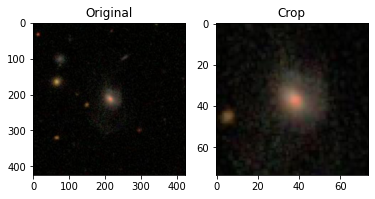

In [ ]:
## TODO: Delete maybe later, this is mainly for visualization.

fig, ax = plt.subplots(1,2)

# Original
random = df.sample()['GalaxyID'].values[0]
img = mpimg.imread(data_folder+'images_train_rev1/'+random)
img = img/255

input = np.array([img])

model_crop = keras.models.Sequential()
model_crop.add(keras.layers.MaxPooling2D((2, 2), input_shape=(424, 424, 3)))
model_crop.add(keras.layers.Cropping2D(cropping=((69, 69))))
          
model_crop.summary()
outputs = model_crop.predict(input)

ax[0].set_title('Original')
ax[0].imshow(img)
ax[1].set_title('Crop')
ax[1].imshow(outputs[0])

np.shape(outputs[0])

In [ ]:
def plot_history(acc, val_acc, loss, val_loss, epochs):

  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('model rmse')
  plt.ylabel('rmse')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

### Model definition

The defined model consists in a brief preprocessing layer, which includes one crop layer following with one batch normalization layer. Then, 3 convolution layers are defined, which each of them included 2 covolutional layers and one non-linear activation layer per each convolution, ReLU in this case, and a downsampling layer (maxpooling). Defined in the next way:


*   1st conv layer: 128@Conv_2D (3, 3) 'valid' padding + 128@Conv_2D (3, 3) 'valid' padding
*   2nd conv layer: 64@Conv_2D (3, 3) 'valid' padding + 64@Conv_2D (3, 3) 'valid' padding
*   3rd conv layer: 32@Conv_2D (3, 3) 'valid' padding + 32@Conv_2D (3, 3) 'valid' padding

Then, a flatten layer is defined, which results in 800 neurons followed by a dropout layer, deciding whether a neuron is activated or not, in order to avoid, inter alia, overfitting.

Ending up with 3 fully conected layers, the first 2 activated by ReLU, and the last one (with 37 neurons), activated via Sigmoid, in order to predict the desired values.

****
The batch normalization in the preprocessing stage was made in order to make an overall denoise over the cropped images.  This method can not only prevent exploding or vanishing gradients, and accelerate the convergence of training the network, but can also improve performance.
Source: https://arxiv.org/pdf/1702.03275.pdf

The selected loss was keras' [BinaryCrossEntropy](https://keras.io/api/losses/probabilistic_losses), which computes the cross-entropy loss between true labels and predicted labels. This kind of cross-entropy is optimized for problems whose class label is intented to be between 0 and 1 (probabilities).
And our choice for the optimizer was the *adam* optimizer, defined with learning rate of 0.001 (default).



In [ ]:
def model_custom():
    model = keras.models.Sequential()
    model.add(keras.layers.Cropping2D(cropping=(69, 69), input_shape=(img_height, img_width, 3)))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.5))

    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))

    model.add(keras.layers.Dense(37, activation='sigmoid'))

    model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
    model.summary()
    return model


In [ ]:
model_1 = model_custom()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 74, 74, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 74, 74, 3)         12        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 128)       3584      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 70, 70, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 33, 64)        73792     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 31, 31, 64)       

The model is fitted and trained.

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
              filepath=models_folder+'model_1.h5',
              monitor = 'val_root_mean_squared_error',
              mode='max', save_best_only = True)

history = model_1.fit(
          train_generator,
          validation_data=test_generator,
          validation_steps=15,
          epochs=10,
          verbose=1,
          callbacks=[checkpoint])

model_1.save(models_folder+'model_1.h5') # Cloud

Epoch 1/10
844/844 [==============================] - 1693s 2s/step - loss: 0.2818 - root_mean_squared_error: 0.1470 - val_loss: 0.2753 - val_root_mean_squared_error: 0.1369
Epoch 2/10
844/844 [==============================] - 1686s 2s/step - loss: 0.2797 - root_mean_squared_error: 0.1452 - val_loss: 0.2789 - val_root_mean_squared_error: 0.1458
Epoch 3/10
844/844 [==============================] - 1684s 2s/step - loss: 0.2775 - root_mean_squared_error: 0.1430 - val_loss: 0.2732 - val_root_mean_squared_error: 0.1322
Epoch 4/10
844/844 [==============================] - 1675s 2s/step - loss: 0.2742 - root_mean_squared_error: 0.1396 - val_loss: 0.2686 - val_root_mean_squared_error: 0.1339
Epoch 5/10
844/844 [==============================] - 1681s 2s/step - loss: 0.2692 - root_mean_squared_error: 0.1340 - val_loss: 0.2653 - val_root_mean_squared_error: 0.1300
Epoch 6/10
844/844 [==============================] - 1680s 2s/step - loss: 0.2662 - root_mean_squared_error: 0.1307 - val_loss: 0

Once the training is over, the model is test with the data defined as 'validation'. The metric we used is Root Mean Squared Error.

In [ ]:
# The model could be loaded from the save file
model_1 = load_model(models_folder+'model_1.h5')

predictions = model_1.predict(test_generator)

rmse = mean_squared_error(test_generator.labels, predictions, squared=False)
rmse


0.19709530577189951

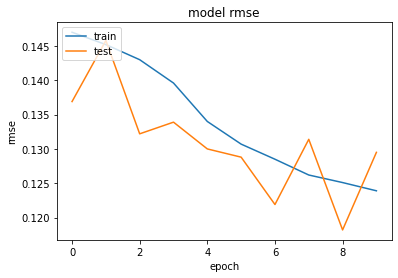

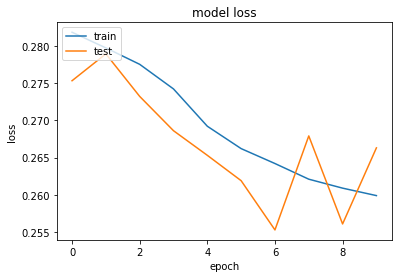

In [ ]:
# In case the execution halted, and restarted the kernel, define the RMSEs and losses by hand
epochs = range(10)
rmse_model_1 = [0.1470, 0.1452, 0.1430, 0.1396, 0.1340, 0.1307, 0.1285, 0.1262, 0.1251, 0.1239]
val_rmse_model_1 = [0.1369, 0.1458, 0.1322, 0.1339, 0.1300, 0.1288, 0.1219, 0.1314, 0.1182, 0.1295]
loss_model_1 = [0.2818, 0.2797, 0.2775, 0.2742, 0.2692, 0.2662, 0.2642, 0.2621, 0.2609, 0.2599]
val_loss_model_1 = [0.2753, 0.2789, 0.2732, 0.2686, 0.2653, 0.2619, 0.2553, 0.2679, 0.2561, 0.2663]

plot_history(rmse_model_1, val_rmse_model_1, loss_model_1, val_loss_model_1, epochs)

## Transfer Learning: Resnet50.
Apart from defining a whole 'raw' model, we decided to use the transfer learning technique with the predefined (and pretrained) [Resnet-50](https://arxiv.org/pdf/1512.03385.pdf) net. The central architecture of the net is fully defined with the Resnet, but few changes were made in order to fit our original data and accomplish the problem's objetive:


*   Input layer (212, 212, 3): Cropping layer (size: 69, 69)
*   Output layers: Flatten (18432 neurons) + FC (37 neurons)

The optimizer and loss functions are defined in the same way as the first model we defined.

The first 143 layers of the Resnet-50 are disabled (not trainables), meaning that the parameters defined in those layers are not getting trained. The only trainable parameters are the ones defined in the last convolution layer of the resnet and the ones defines in the "output layers". This was set in this way due to the lack of computational resources we had. So the model finally ended up with 15,658,021 trainable parameters, and 8,611,712 non-trainable parameters. With this settings we could to take advantage of the trained Resnet-50 while we fit the model to our requirements.



In [ ]:
model_ResNet50 = ResNet50(weights='imagenet', include_top=False)

for layer in model_ResNet50.layers[:143]:
  layer.trainable = False

model_2 = keras.models.Sequential()
model_2.add(keras.layers.Cropping2D(cropping=(69, 69), input_shape=(212, 212, 3)))
model_2.add(model_ResNet50)
model_2.add(keras.layers.Flatten())
model_2.add(keras.layers.Dense(37, activation='sigmoid'))

model_2.compile(loss=keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
model_2.summary()


94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d (Cropping2D)      (None, 74, 74, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 37)                682021    
Total params: 24,269,733
Trainable params: 15,658,021
Non-trainable params: 8,611,712
_________________________________________________________________


The model is fitted and trained.

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
              filepath=models_folder+'model_2_val.h5',
              monitor = 'val_root_mean_squared_error',
              mode='max', save_best_only = True)

history_2 = model_2.fit(
          train_generator,
          validation_data=test_generator,
          validation_steps=15,
          epochs=35,
          verbose=1,
          callbacks=[checkpoint])

# model_2.save('../home/unaice/UNI/CUARTO/MLNN/galaxy-zoo/models/model_2.h5') # LOCAL
model_2.save(models_folder+'model_2.h5') # Cloud

Epoch 1/35
844/844 [==============================] - 5116s 6s/step - loss: 0.3010 - root_mean_squared_error: 0.1646 - val_loss: 0.2948 - val_root_mean_squared_error: 0.1589
Epoch 2/35
844/844 [==============================] - 1017s 1s/step - loss: 0.2888 - root_mean_squared_error: 0.1552 - val_loss: 0.3063 - val_root_mean_squared_error: 0.1655
Epoch 3/35
844/844 [==============================] - 1004s 1s/step - loss: 0.2844 - root_mean_squared_error: 0.1510 - val_loss: 0.3065 - val_root_mean_squared_error: 0.1704
Epoch 4/35
844/844 [==============================] - 994s 1s/step - loss: 0.2810 - root_mean_squared_error: 0.1478 - val_loss: 0.3509 - val_root_mean_squared_error: 0.1764
Epoch 5/35
844/844 [==============================] - 977s 1s/step - loss: 0.2796 - root_mean_squared_error: 0.1463 - val_loss: 1.8224 - val_root_mean_squared_error: 0.4107
Epoch 6/35
844/844 [==============================] - 975s 1s/step - loss: 0.2783 - root_mean_squared_error: 0.1447 - val_loss: 0.33

Once the training is over, the model is test with the data defined as 'validation'. The metric we used is Root Mean Squared Error.

In [ ]:
# The model could be loaded from the save file
model_2 = load_model(models_folder+'model_2.h5')

predictions = model_2.predict(test_generator)

rmse = mean_squared_error(test_generator.labels, predictions, squared=False)
rmse


0.22349962399141185

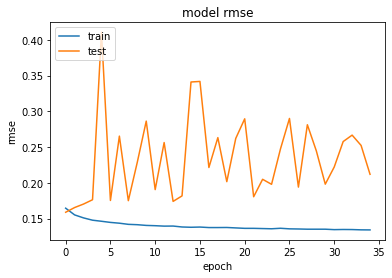

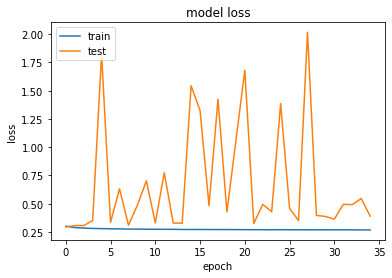

In [ ]:
# In case the execution halted, and restarted the kernel, define the RMSEs and losses by hand
epochs = range(35)
rmse_model_2 = [0.1646,	0.1552,	0.1510,	0.1478,	0.1463,	0.1447,	0.1436,	0.1420,	0.1415,	0.1405,	0.1401,	0.1395,	0.1396,	0.1383,	0.1379,	0.1382,	0.1375,	0.1375,	0.1376,	0.1370,	0.1364,	0.1364,	0.1361,	0.1358,	0.1365,	0.1357,	0.1355,	0.1352,	0.1352,	0.1352,	0.1346,	0.1348,	0.1347,	0.1343,	0.1342]
val_rmse_model_2 = [0.1589,	0.1655,	0.1704,	0.1764,	0.4107,	0.1754,	0.2654,	0.1751,	0.2288,	0.2864,	0.1906,	0.2564,	0.1741,	0.1818,	0.3411,	0.3419,	0.2215,	0.2633,	0.2017,	0.2622,	0.2896,	0.1806,	0.2050,	0.1980,	0.2477,	0.2901,	0.1941,	0.2813,	0.2448,	0.1982,	0.2222,	0.2578,	0.2668,	0.2524,	0.2120]
loss_model_2 = [0.3010,	0.2888,	0.2844,	0.2810,	0.2796,	0.2783,	0.2771,	0.2756,	0.2752,	0.2742,	0.2738,	0.2733,	0.2734,	0.2720,	0.2718,	0.2719,	0.2714,	0.2713,	0.2713,	0.2708,	0.2703,	0.2702,	0.2699,	0.2696,	0.2702,	0.2695,	0.2694,	0.2691,	0.2690,	0.2691,	0.2685,	0.2688,	0.2686,	0.2682,	0.2681]
val_loss_model_2 = [0.2948,	0.3063,	0.3065,	0.3509,	1.8224,	0.3348,	0.6321,	0.3104,	0.4872,	0.7019,	0.3300, 0.7746,	0.3291,	0.3279	,1.5439,	1.3240,	0.4830,	1.4237,	0.4260,	1.0557,	1.6819,	0.3252,	0.4942,	0.4292,	1.3854,	0.4590,	0.3506,	2.0173,	0.3963,	0.3871,	0.3636,	0.4947,	0.4917,	0.5454,	0.3898]

plot_history(rmse_model_2, val_rmse_model_2, loss_model_2, val_loss_model_2, epochs)